# Algorithme de **Deutsch–Jozsa** — Notebook pédagogique

Objectif : Déterminer si une fonction booléenne $$ f:\{0,1\}^n\to\{0,1\} $$ est **constante** ou **équilibrée** avec **un seul** appel à l'oracle.

Public : Débutants. Nous travaillerons d'abord avec $n=2$ puis $n=3$.

**Prérequis utiles** : qubit, portes X/H/Z, mesure, oracle.


## 1. Installation et imports
```bash
pip install qiskit qiskit-aer  # Qiskit n'est pas installé 
```

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import math
%matplotlib inline

## 2. Idée générale
- Préparer une superposition uniforme sur les $n$ qubits d'entrée.
- Utiliser un qubit auxiliaire en état $|1\rangle$ et appliquer la porte H pour obtenir $| - \rangle$.
- Appeler **l'oracle** qui encode $f(x)$ sous forme de phase.
- Annuler la superposition par des Hadamard et mesurer.
- **Sortie** :
  - Si tous les résultats sont $0\ldots 0$, on conclut que la fonction est **constante**.
  - Sinon, elle est **équilibrée**.

## 3. Boîte à outils : oracles simples pour $n=2$
On définit quatre oracles :
- 2 **constants** : $f(x)=0$ et $f(x)=1$, 
- 2 **équilibrés** : $f(x)=x_0$ et $f(x)=x_0\oplus x_1$

Ces oracles sont implémentés en **ajout de phase** sur l'auxiliaire.

In [2]:
# Oracles Deutsch–Jozsa pour n=2
def oracle_constant_0(n=2):
    qc = QuantumCircuit(n+1)
    # f(x)=0 -> rien à faire
    return qc

def oracle_constant_1(n=2):
    qc = QuantumCircuit(n+1)
    # f(x)=1 -> flip inconditionnel du qubit auxiliaire
    qc.x(n)
    return qc

def oracle_fx_eq_x0(n=2):
    qc = QuantumCircuit(n+1)
    # f(x)=x0 -> CNOT du premier qubit vers l'auxiliaire
    qc.cx(0, n)
    return qc

def oracle_fx_eq_x0_x1(n=2):
    qc = QuantumCircuit(n+1)
    # f(x)=x0 XOR x1 -> deux CNOT successifs
    qc.cx(0, n)
    qc.cx(1, n)
    return qc

## 4. Circuit Deutsch–Jozsa générique
Fonction utilitaire qui :
1. initialise, 
2. met les $n$ qubits d'entrée en superposition, 
3. prépare le qubit auxiliaire en $| - \rangle$, 
4. applique l'oracle, 
5. applique H à nouveau, 
6. mesure.

In [3]:
def deutsch_jozsa_run(oracle_circuit, n=2, shots=1024):
    qc = QuantumCircuit(n+1, n)
    # Étape 1-2 : superposition sur les n qubits d'entrée
    qc.h(range(n))
    # Étape 3 : auxiliaire en |1> puis H -> |->
    qc.x(n)
    qc.h(n)
    # Étape 4 : oracle (agit sur n+1 qubits dans le même ordre)
    qc.compose(oracle_circuit, inplace=True)
    # Étape 5 : annuler la superposition
    qc.h(range(n))
    # Étape intermédiaire pour faciliter la lisibilité
    qc.barrier()
    # Étape 6 : mesure
    qc.measure(range(n), range(n))
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    return qc, counts

## 5. Démonstration pour $n=2$
Exécutons les quatre cas et analysons la sortie.

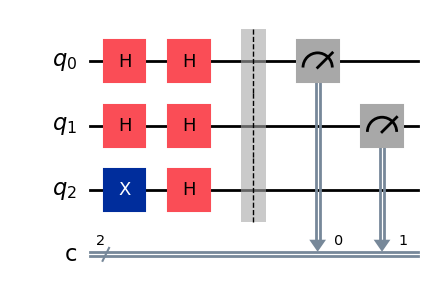

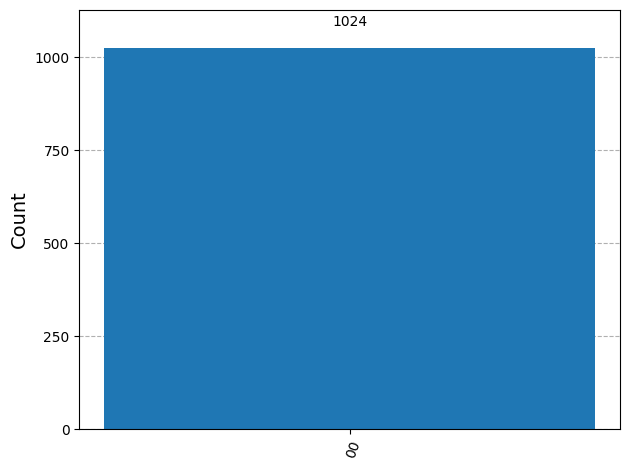

Verdict attendu : CONSTANTE (sortie 00). Comptes: {'00': 1024}


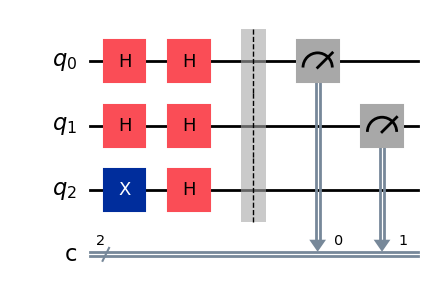

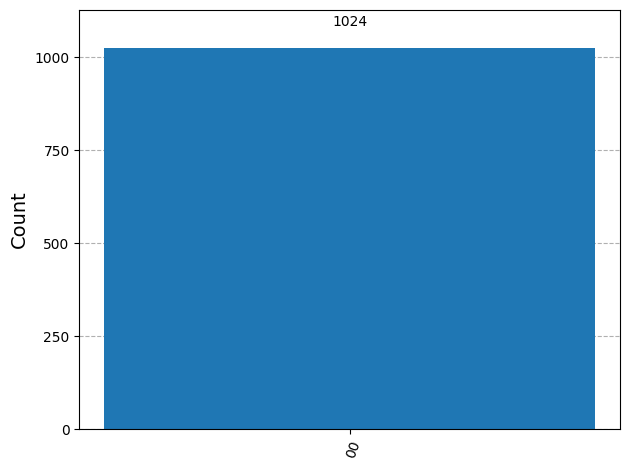

In [4]:
# Cas 1 : constant f(x)=0
qc, counts = deutsch_jozsa_run(oracle_constant_0())
display(qc.draw('mpl'))
display(plot_histogram(counts))
print('Verdict attendu : CONSTANTE (sortie 00). Comptes:', counts)

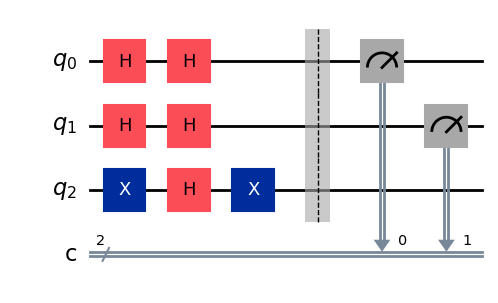

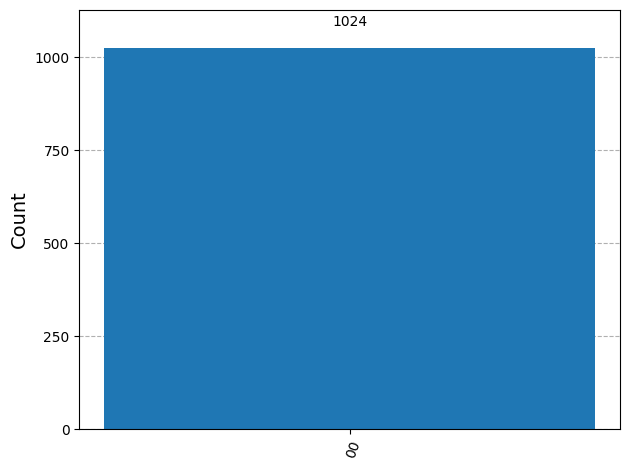

Verdict attendu : CONSTANTE (sortie 00). Comptes: {'00': 1024}


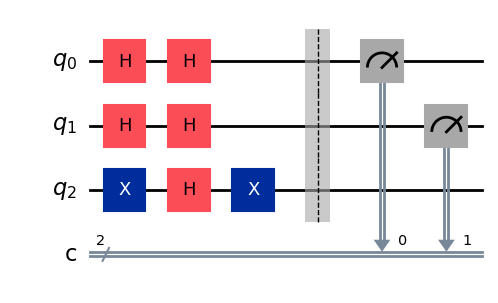

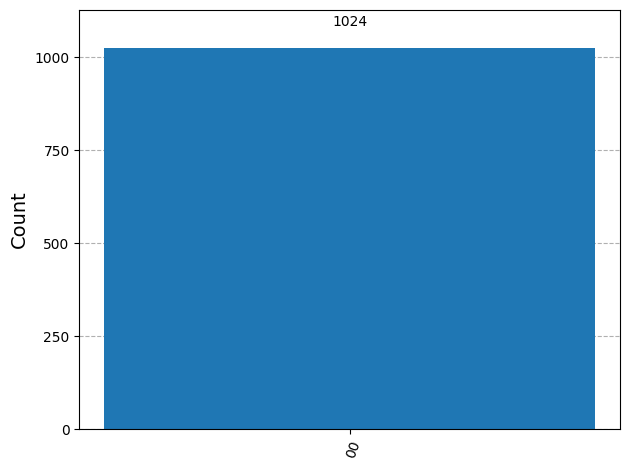

In [5]:
# Cas 2 : constant f(x)=1
qc, counts = deutsch_jozsa_run(oracle_constant_1())
display(qc.draw('mpl'))
display(plot_histogram(counts))
print('Verdict attendu : CONSTANTE (sortie 00). Comptes:', counts)

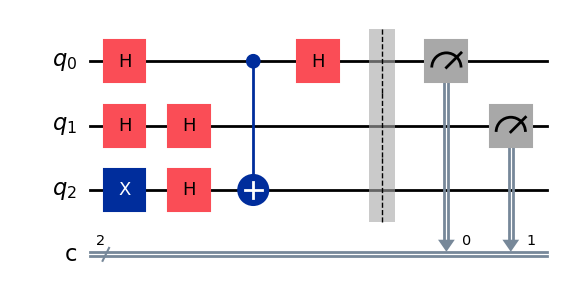

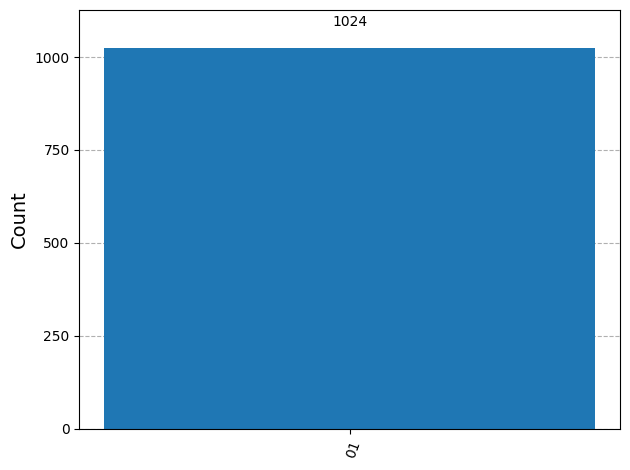

Verdict attendu : ÉQUILIBRÉE (sortie différente de 00). Comptes: {'01': 1024}


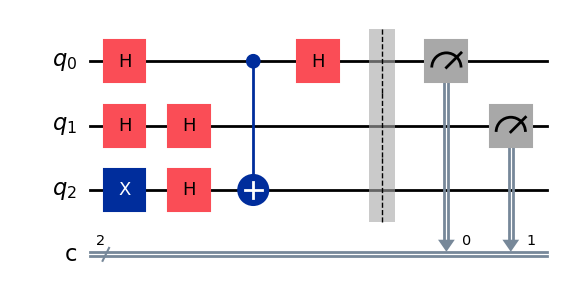

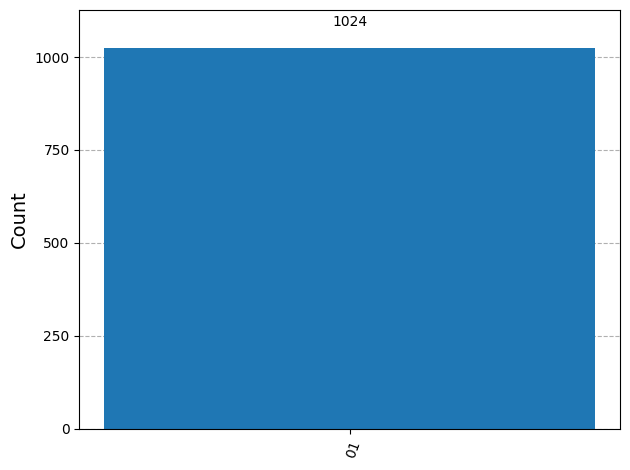

In [6]:
# Cas 3 : équilibrée f(x)=x0
qc, counts = deutsch_jozsa_run(oracle_fx_eq_x0())
display(qc.draw('mpl'))
display(plot_histogram(counts))
print('Verdict attendu : ÉQUILIBRÉE (sortie différente de 00). Comptes:', counts)

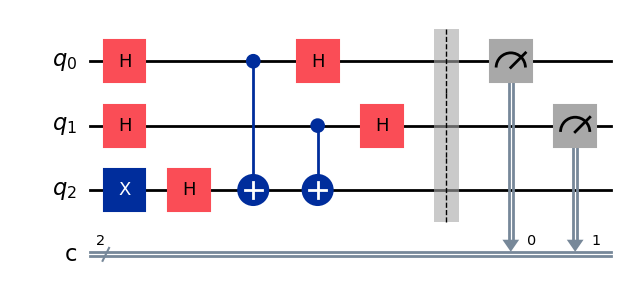

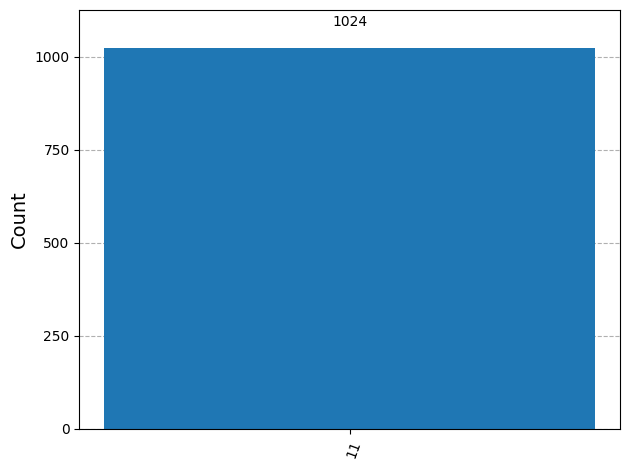

Verdict attendu : ÉQUILIBRÉE (sortie différente de 00). Comptes: {'11': 1024}


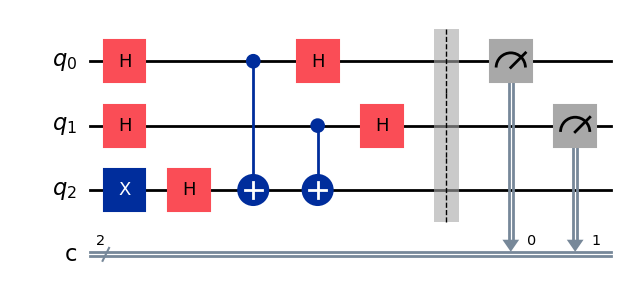

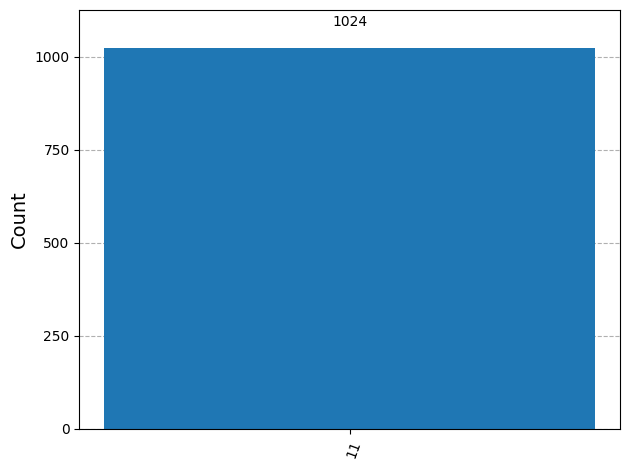

In [7]:
# Cas 4 : équilibrée f(x)=x0 XOR x1
qc, counts = deutsch_jozsa_run(oracle_fx_eq_x0_x1())
display(qc.draw('mpl'))
display(plot_histogram(counts))
print('Verdict attendu : ÉQUILIBRÉE (sortie différente de 00). Comptes:', counts)

## 6. Extension à $n=3$
Exemple d'une fonction **équilibrée** : $$f(x)=x_0\oplus x_1\oplus x_2$$.

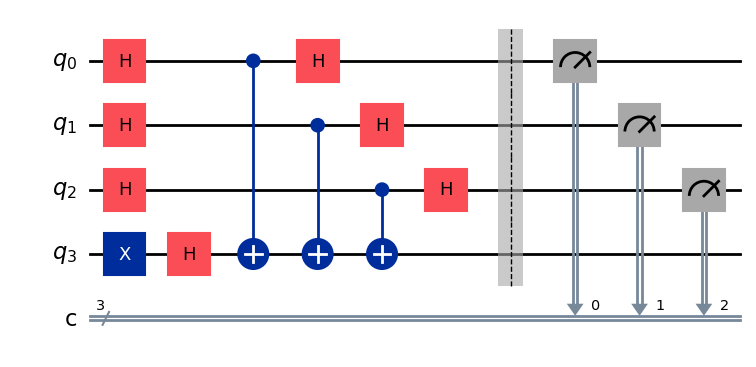

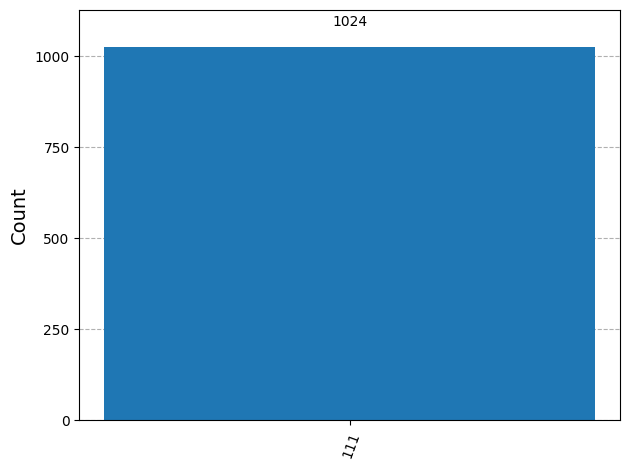

Verdict attendu : ÉQUILIBRÉE (sortie différente de 000). Comptes: {'111': 1024}


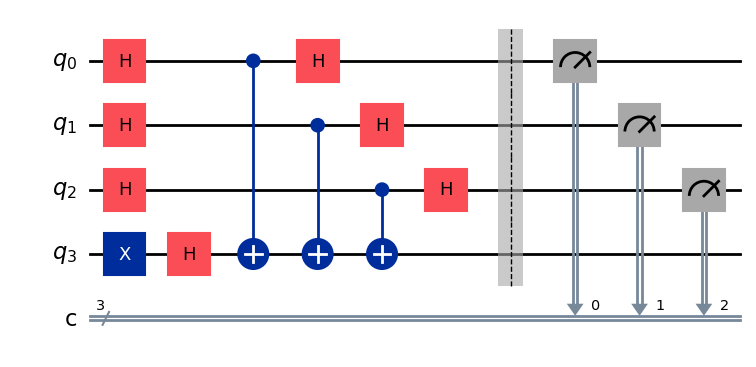

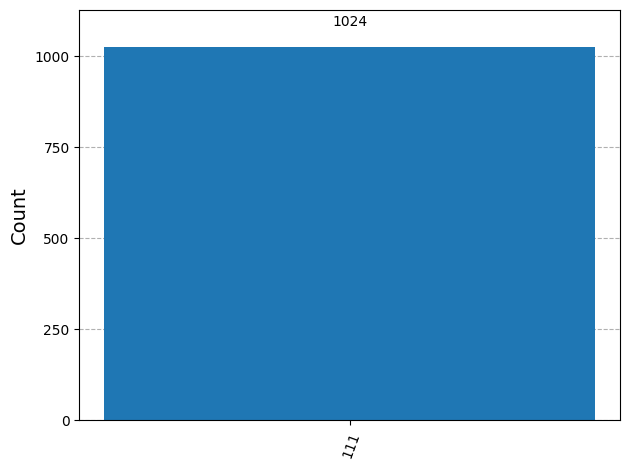

In [8]:
def oracle_n3_xor(n=3):
    qc = QuantumCircuit(n+1)
    qc.cx(0, n)
    qc.cx(1, n)
    qc.cx(2, n)
    return qc

qc, counts = deutsch_jozsa_run(oracle_n3_xor(n=3), n=3)
display(qc.draw('mpl'))
display(plot_histogram(counts))
print('Verdict attendu : ÉQUILIBRÉE (sortie différente de 000). Comptes:', counts)

## 7. NB
- **Parallélisme quantique** : tous les inputs sont testés en une passe.
- **Kickback de phase** : l'oracle encode l'information sans la mesurer.
- **Interférence** : les Hadamard finales concentrent l'amplitude sur $0\ldots 0$ pour les fonctions constantes.
- Limites : DJ est surtout un *problème jouet* mais excellent pour comprendre la **logique** des algorithmes quantiques.